## Imports & Setup

In [29]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Preparazione dei tre dataset (Industriale, Scolastico e Residenziale)

In [30]:
import pandas as pd

df = pd.read_csv(
    "/home/samuel/Desktop/Appunti/Insite/TensorFlow/opsd-household_data-2020-04-15/household_data_15min_singleindex.csv"
)

df_industrial = df.copy()
df_residential = df.copy()
df_school = df.copy()

timestamp_column = "utc_timestamp"

data_column_industrial = "DE_KN_industrial1_grid_import"
data_column_school = "DE_KN_public1_grid_import"
data_column_residential = "DE_KN_residential1_grid_import"

df_industrial = df_industrial[[timestamp_column, data_column_industrial]]
df_residential = df_residential[[timestamp_column, data_column_residential]]
df_school = df_school[[timestamp_column, data_column_school]]

# Calcolo della differenza tra il valore corrente e quello precedente nella colonna, ottenendo così il consumo istantaneo
df_industrial[f"{data_column_industrial}_instantaneous"] = df_industrial[data_column_industrial].diff()
df_residential[f"{data_column_residential}_instantaneous"] = df_residential[data_column_residential].diff()
df_school[f"{data_column_school}_instantaneous"] = df_school[data_column_school].diff()


# Rimuove righe con campi vuoti
df_industrial.dropna(inplace=True)
df_residential.dropna(inplace=True)
df_school.dropna(inplace=True)

df_industrial
df_residential
df_school

,utc_timestamp,DE_KN_public1_grid_import,DE_KN_public1_grid_import_instantaneous
50178,2016-05-17T10:15:00Z,0.428,0.395
50179,2016-05-17T10:30:00Z,0.755,0.327
50180,2016-05-17T10:45:00Z,1.105,0.350
50181,2016-05-17T11:00:00Z,1.695,0.590
50182,2016-05-17T11:15:00Z,2.166,0.471
...,...,...,...
68369,2016-11-22T22:00:00Z,12312.401,0.352
68370,2016-11-22T22:15:00Z,12312.767,0.366
68371,2016-11-22T22:30:00Z,12313.153,0.386
68372,2016-11-22T22:45:00Z,12313.510,0.357


### Rimozione della colonna timestamp

In [31]:
date_time_industrial = pd.to_datetime(df_industrial.pop(timestamp_column), format='ISO8601')

date_time_residential = pd.to_datetime(df_residential.pop(timestamp_column), format='ISO8601')

date_time_school = pd.to_datetime(df_school.pop(timestamp_column), format='ISO8601')

### Grafici e Statistiche

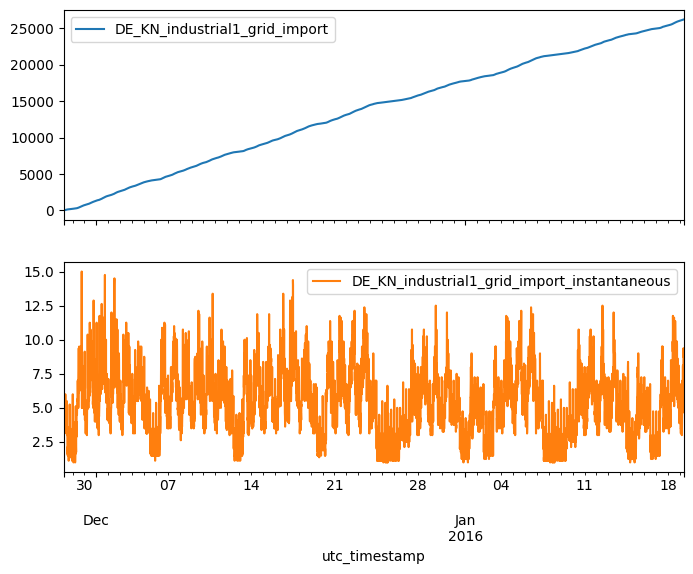

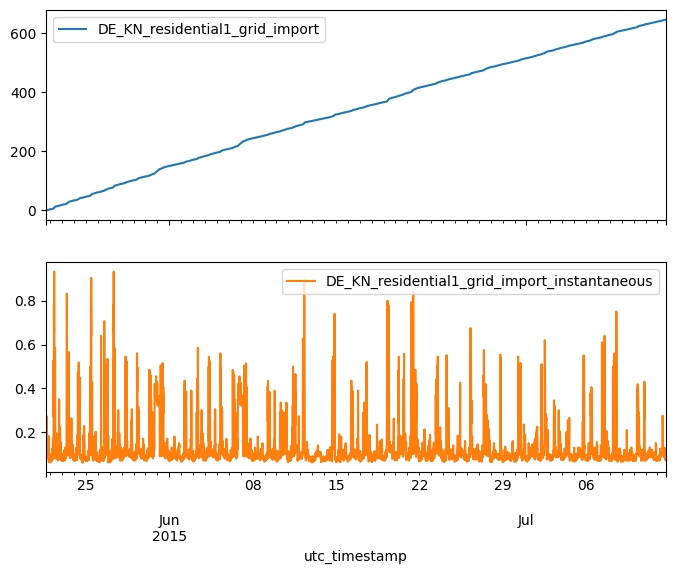

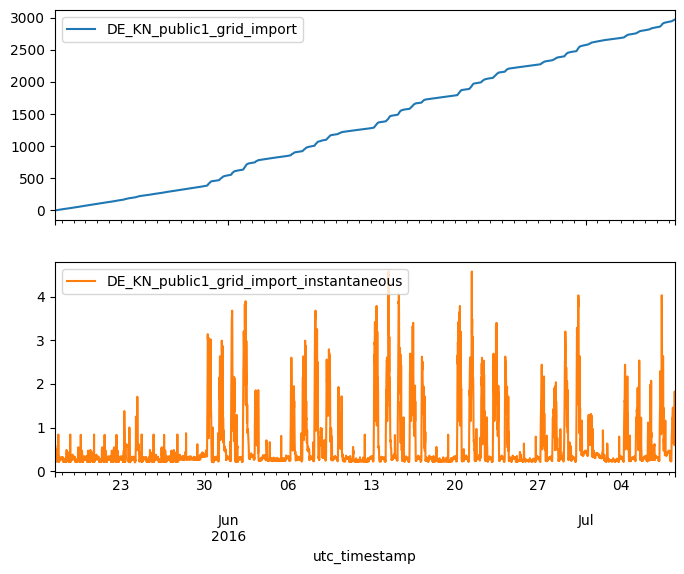

In [32]:
plot_cols = [data_column_industrial, f"{data_column_industrial}_instantaneous"]
plot_features = df_industrial[plot_cols][:5000]
plot_features.index = date_time_industrial[:5000]
_ = plot_features.plot(subplots=True)

plot_cols = [data_column_residential, f"{data_column_residential}_instantaneous"]
plot_features = df_residential[plot_cols][:5000]
plot_features.index = date_time_residential[:5000]
_ = plot_features.plot(subplots=True)

plot_cols = [data_column_school, f"{data_column_school}_instantaneous"]
plot_features = df_school[plot_cols][:5000]
plot_features.index = date_time_school[:5000]
_ = plot_features.plot(subplots=True)

In [33]:
df_industrial.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DE_KN_industrial1_grid_import,65729.0,221557.460564,149025.215303,4.375,77554.436,224835.930,334319.258,511112.711
DE_KN_industrial1_grid_import_instantaneous,65729.0,7.776053,4.745445,0.688,4.391,6.875,10.125,40.828


In [34]:
df_residential.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DE_KN_residential1_grid_import,63486.0,4447.022994,2650.303320,0.107,2043.9585,4509.6415,6689.14875,9096.383
DE_KN_residential1_grid_import_instantaneous,63486.0,0.143281,0.115451,0.029,0.0900,0.1100,0.14500,1.663


In [35]:
df_school.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DE_KN_public1_grid_import,18196.0,5202.128433,3272.366884,0.428,2679.304,4823.523,7405.5125,12313.546
DE_KN_public1_grid_import_instantaneous,18196.0,0.676715,0.757493,0.036,0.279,0.361,0.6150,5.113


Una volta visualizzati i dati contenuti nei dataset e misure come deviazione standard, minimi e massimi, possiamo giudicare la qualità del dataset, ed eventualmente eliminare dati nulli o errati (ad esempio se notiamo minimi o massimi che non hanno senso).
In questo caso, a parte la rimozione dei campi vuoti già effettuata, possiamo tenere i dataset così come sono.

### Coversione della data

Affinché i modelli performino al meglio, ha senso passare al modello, invece che la data o il timestamp, il periodo dell'anno e l'ora del giorno, dal momento che in base a queste due frequenze varia l'utilizzo di energia.

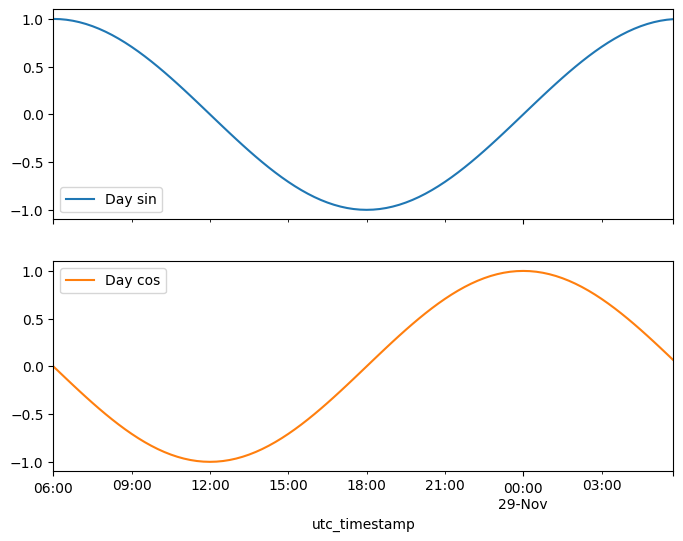

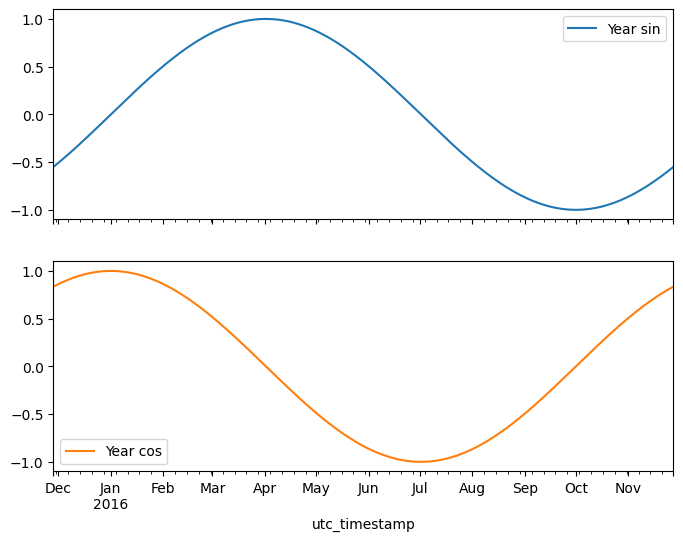

In [9]:
day = 24*60*60
# Considerando la durata reale di un anno, non dobbiamo tenere conto di anni bisestili
# DISCUSS potrebbe essere che così la predizione del modello sia incorretta in vicinanza delle festività
year = (365.2425)*day

timestamp_seconds_industrial = date_time_industrial.map(pd.Timestamp.timestamp)

df_industrial['Day sin'] = np.sin(timestamp_seconds_industrial * (2 * np.pi / day))
df_industrial['Day cos'] = np.cos(timestamp_seconds_industrial * (2 * np.pi / day))
df_industrial['Year sin'] = np.sin(timestamp_seconds_industrial * (2 * np.pi / year))
df_industrial['Year cos'] = np.cos(timestamp_seconds_industrial * (2 * np.pi / year))

timestamp_seconds_residential = date_time_residential.map(pd.Timestamp.timestamp)

df_residential['Day sin'] = np.sin(timestamp_seconds_residential * (2 * np.pi / day))
df_residential['Day cos'] = np.cos(timestamp_seconds_residential * (2 * np.pi / day))
df_residential['Year sin'] = np.sin(timestamp_seconds_residential * (2 * np.pi / year))
df_residential['Year cos'] = np.cos(timestamp_seconds_residential * (2 * np.pi / year))

timestamp_seconds_school = date_time_industrial.map(pd.Timestamp.timestamp)

df_school['Day sin'] = np.sin(timestamp_seconds_school * (2 * np.pi / day))
df_school['Day cos'] = np.cos(timestamp_seconds_school * (2 * np.pi / day))
df_school['Year sin'] = np.sin(timestamp_seconds_school * (2 * np.pi / year))
df_school['Year cos'] = np.cos(timestamp_seconds_school * (2 * np.pi / year))

plot_cols = ['Day sin', 'Day cos']
plot_features = df_industrial[plot_cols][:96]
plot_features.index = date_time_industrial[:96]
_ = plot_features.plot(subplots=True)

plot_cols = ['Year sin', 'Year cos']
plot_features = df_industrial[plot_cols][:35064]
plot_features.index = date_time_industrial[:35064]
_ = plot_features.plot(subplots=True)

#### Analisi delle frequenze migliori tramite trasformate di Fourier

Non dobbiamo usare necessariamente quello giornaliero e quello annuale come periodi per codificare i timestamp nei dataset; a seconda del dataset o del caso di utilizzo potrebbero infatti esserci frequenze migliori. Per ricavare tali frequenze possiamo applicare delle trasformate di Fourier ai dati registrati e cercare le frequenze che hanno maggiore peso nel risultato finale.

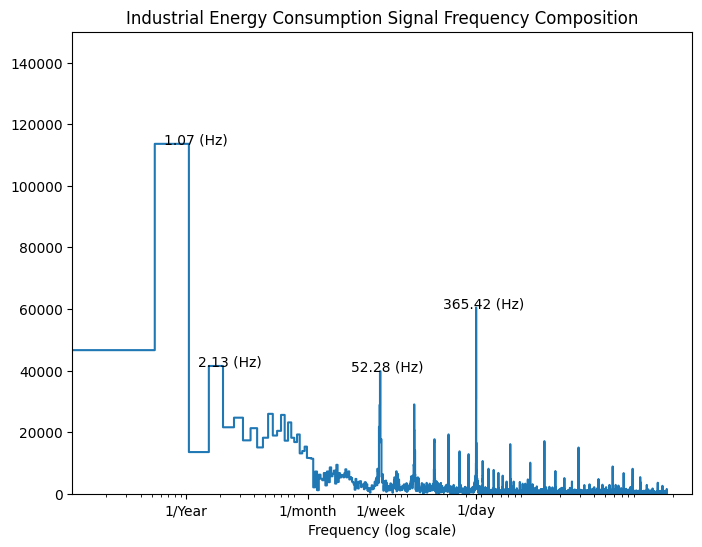

In [23]:
fft = tf.signal.rfft(df_industrial[f"{data_column_industrial}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df_industrial[f"{data_column_industrial}_instantaneous"])
# Ricavo i quarti d'ora in un anno dal momento che abbiamo un sample ogni quarto d'ora
hours_quarters_per_year = 24*365.2524*4
years_per_dataset = n_samples/(hours_quarters_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 150000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 365.2524/7, 365.2524], labels=['1/Year', '1/month', '1/week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
_ = plt.title('Industrial Energy Consumption Signal Frequency Composition')

# Ricerca dei valori massimi dei "pesi" delle frequenze
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
  if f_per_year[idx] >= 1 and not any(
    [
      abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
      for last_frequency in f_per_year[top_4_indices]
    ] if top_4_indices else [False]
  ):
    top_4_indices.append(idx)
    if len(top_4_indices) == 4:
      break  # Stop after finding 4 valid frequencies
top_4_frequencies_industrial = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_industrial, top_4_magnitudes)):
  plt.annotate(f"{freq:.2f} (Hz)", (freq, mag), xytext=(5, 0), 
               textcoords="offset points", ha='center')

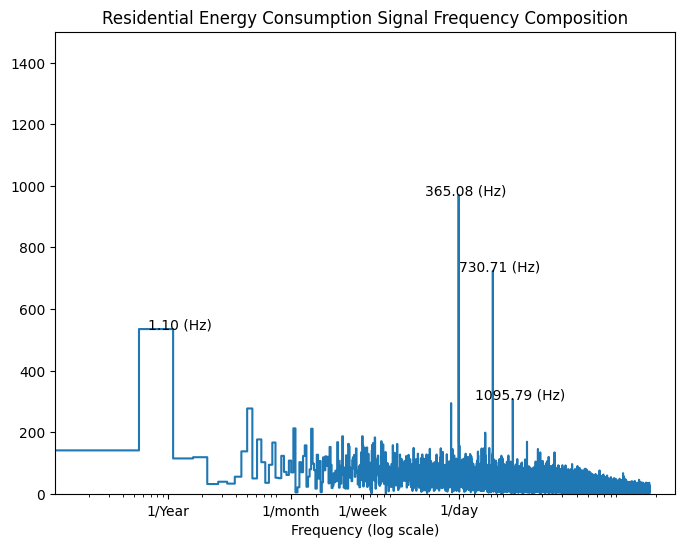

In [24]:
fft = tf.signal.rfft(df_residential[f"{data_column_residential}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df_residential[f"{data_column_residential}_instantaneous"])
hours_quarters_per_year = 24*365.2524*4
years_per_dataset = n_samples/(hours_quarters_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1500)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 365.2524/7, 365.2524], labels=['1/Year', '1/month', '1/week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
_ = plt.title('Residential Energy Consumption Signal Frequency Composition')


# Ricerca dei valori massimi dei "pesi" delle frequenze
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
  if f_per_year[idx] >= 1 and not any(
    [
      abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
      for last_frequency in f_per_year[top_4_indices]
    ] if top_4_indices else [False]
  ):
    top_4_indices.append(idx)
    if len(top_4_indices) == 4:
      break  # Stop after finding 4 valid frequencies
top_4_frequencies_residential = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_residential, top_4_magnitudes)):
  plt.annotate(f"{freq:.2f} (Hz)", (freq, mag), xytext=(5, 0), 
               textcoords="offset points", ha='center')

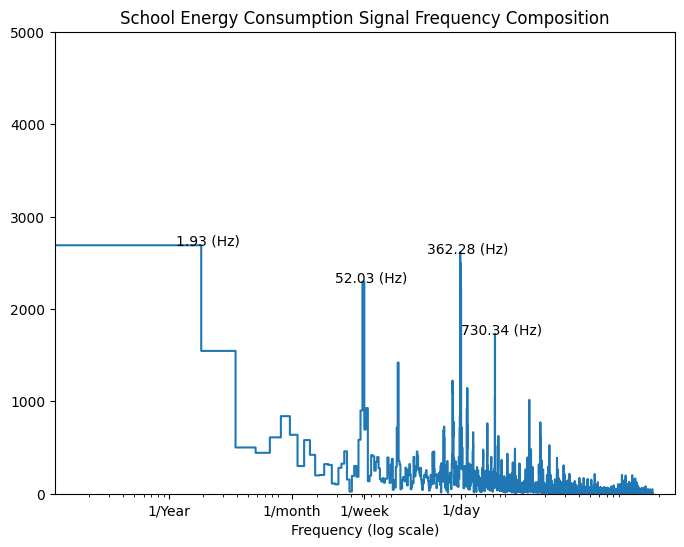

In [25]:
fft = tf.signal.rfft(df_school[f"{data_column_school}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_school[f"{data_column_school}_instantaneous"])
hours_quarters_per_year = 24*365.2524*4
years_per_dataset = n_samples_h/(hours_quarters_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 5000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 365.2524/7, 365.2524], labels=['1/Year', '1/month', '1/week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
_ = plt.title('School Energy Consumption Signal Frequency Composition')


# Ricerca dei valori massimi dei "pesi" delle frequenze
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
  if f_per_year[idx] >= 1 and not any(
    [
      abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
      for last_frequency in f_per_year[top_4_indices]
    ] if top_4_indices else [False]
  ):
    top_4_indices.append(idx)
    if len(top_4_indices) == 4:
      break  # Stop after finding 4 valid frequencies
top_4_frequencies_school = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_school, top_4_magnitudes)):
  plt.annotate(f"{freq:.2f} (Hz)", (freq, mag), xytext=(5, 0), 
               textcoords="offset points", ha='center')

In [28]:
best_frequencies_results = pd.DataFrame([
    ['Industriale', 'Residenziale', 'Scolastico'],
    [top_4_frequencies_industrial[0], top_4_frequencies_residential[0], top_4_frequencies_school[0]],
    [top_4_frequencies_industrial[1], top_4_frequencies_residential[1], top_4_frequencies_school[1]],
    [top_4_frequencies_industrial[2], top_4_frequencies_residential[2], top_4_frequencies_school[2]],
    [top_4_frequencies_industrial[3], top_4_frequencies_residential[3], top_4_frequencies_school[3]]
])

best_frequencies_results

,0,1,2
0,Industriale,Residenziale,Scolastico
1,1.066933,365.079802,1.92703
2,365.424665,730.711918,362.281563
3,2.133867,1.104629,52.029799
4,52.279733,1095.79172,730.344214


Possiamo notare come non siano ovvie le frequenze più importanti per ogni dataset. La scelta iniziale di utilizzare periodo dell'anno e ora del giorno (ovvero (Year sin, Year cos) e (Day sin, Day cos)) è una buona scelta per tutti i dataset: come è normale aspettarsi infatti, il consumo energetico è influenzato dal periodo dell'anno e ora del giorno, ma emerge dai dati che per ogni dataset esistono altre frequenze dominanti (come il giorno della settimana (~ 52 Hz) o la parte della giornata (mattina / sera, corrispondente alla frequenza di ~ 730 Hz)) e che in ognuno dei dataset l'ordine di importanza delle frequenze è diverso.

È da considerare infine un aspetto importante nella ricerca automatica di tali massimi; tali massimi sono i risultato di un ulteriore operazione di filtraggio rispetto ai massimi reali che tiene in cosiderazione il significato di questi dati:
- sono stati esclusi i massimi < 1, in quanto non ci aspettiamo che i dati abbiano una qualche ciclicità su periodi maggiori di 1 anno
- sono stati tenuti in considerazione dei massimi locali piuttosto che assoluti, laddove infatti si presentasse un massimo vicino (entro log(max)) ad un massimo già trovato, questo non viene preso in considerazione, prendendo solo il maggiore dei due. Questo permette di avere delle frequenze finali ben distribuite, che tengano in considerazione di ciclicità più o meno lunghe